In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/scratch/ewalt/pdm/rs-uncertainty")
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from src.metrics import StratifiedRCU
from src.viz import *
from pathlib import Path
import rasterio
import fiona
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange
import random
import yaml
import fiona
import rasterio.warp
import rasterio.features
sns.set()
sns.set_style("whitegrid")
random.seed(123)

In [2]:
RESDIR = "results/cloud_exp/2023-06-20_16-14-11" #"results/cloud_exp/2023-05-26_15-55-46"
S2DIR = "gee_data/reprojected/"
S2REPRDIR = "gee_data/reprojected_dirs"
GTDIR = "assets/data/preprocessed"
SANITYRESDIR = "results/cloud_exp/2023-05-31_11-23-56_sanity_check" # results
SANITYS2DIR = "assets/data/sentinel_data/s2_reprojected" # s2 reprojected
SANITYS2REPRDIR = "gee_data/sanity_check/" # restructured s2 reprojected
SPLITMASKDIR = "assets/data/split_masks/" # split masks
SHAPEFILES = ['assets/data/NHM_projectDekning_AOI_edit2015_V2.shp', 'assets/data/ALS_projects_Dz_all_norway.shp']
STATSFILE = "data/2023-04-05_18-58-33_baseline/stats.yaml"

In [3]:
with open(STATSFILE, "r") as f:
    stats = yaml.safe_load(f)
TRAINMEANS = stats["labels_stats"]["mean"]
TRAINSTDS = stats["labels_stats"]["std"]
for i in [2,4]:
    TRAINMEANS[i] /= 100
    TRAINSTDS[i] /= 100

In [4]:
VARIABLES = ['P95', 'MeanH', 'Dens', 'Gini', 'Cover']

In [5]:
# Experiment result directories
result_dirs = [p.path for p in os.scandir(RESDIR) if os.path.exists(os.path.join(p.path,"rcu.json"))]
len(result_dirs)

72

## Example exploded plots for presentation

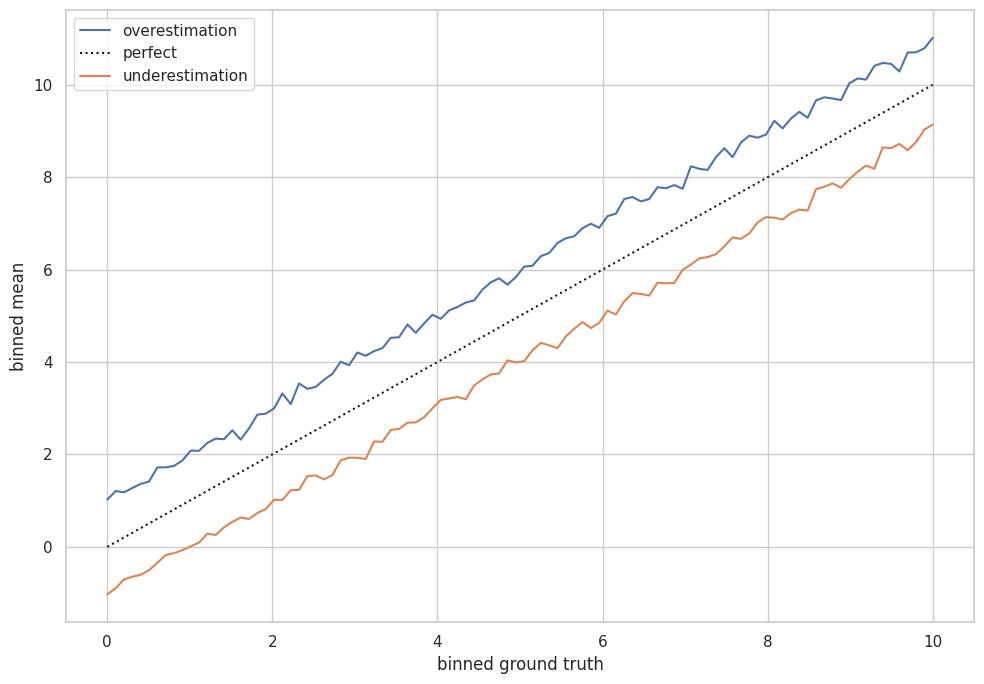

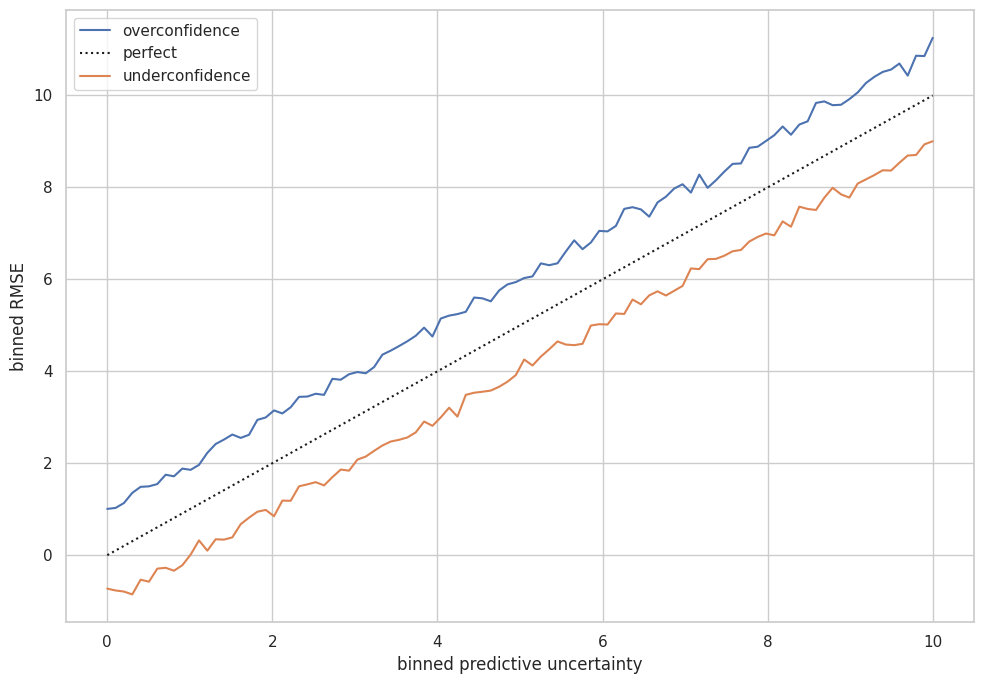

In [456]:
def exploded_plot(over_label, under_label, xlabel, ylabel, save_name):
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10,7))
    x = np.linspace(0, 10, 100)
    over = x+1+0.1*np.random.randn(100)
    under = x-1+0.1*np.random.randn(100)
    ax.plot(x, over, label=over_label)
    ax.plot(x,x,linestyle="dotted", color="k", label="perfect")
    ax.plot(x, under, label=under_label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.tight_layout()
    savefigure(fig, save_name)
    plt.show()
# GT
exploded_plot("overestimation", "underestimation", "binned ground truth", "binned mean", 
             "images/defense/example_rmse_exploded_plot")
# ENCE
exploded_plot("overconfidence", "underconfidence", "binned predictive uncertainty", "binned RMSE", 
             "images/defense/example_ence_exploded_plot")

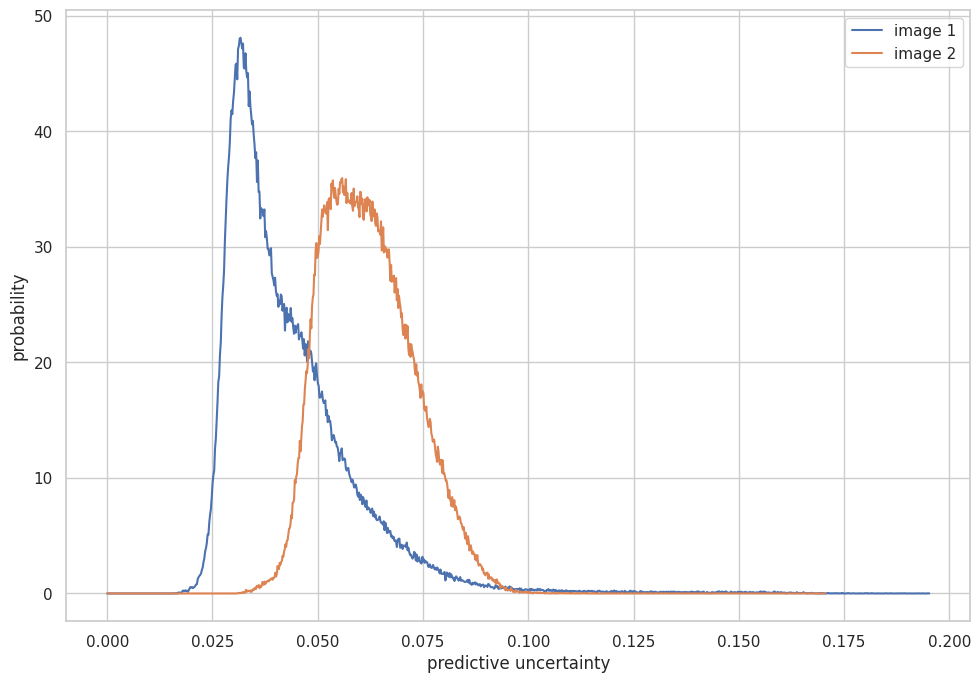

In [491]:
# Usability
i = 0
def addhisto(rd, ax):
    global i
    i += 1
    pred_uncert = loadRaster(
        getPaths(rd, returns=["variance"]),
        bands=VARIABLES.index("Gini")+1,
        elementwise_fn=np.sqrt
    ).reshape(-1)
    pred_uncert = pred_uncert[~np.isnan(pred_uncert)]
    bins = np.linspace(0, pred_uncert.max(), 1000)
    histo = np.histogram(pred_uncert, bins, density=True)[0].tolist()+[0]
    ax.plot(bins, histo, label=f"image {i}")
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10,7))
rds = ['results/cloud_exp/2023-06-20_16-14-11/1023_20180526T105029', 
       'results/cloud_exp/2023-06-20_16-14-11/1023_20180528T104021']
for rd in rds: addhisto(rd, ax)
ax.set_ylabel("probability")
ax.set_xlabel("predictive uncertainty")
ax.legend()
plt.tight_layout()
savefigure(fig, "images/defense/example_predictive_uncertainty_exploded_plot")
plt.show()

## Conditional histograms

In [505]:
bins=np.array([0, EMPIRICAL_CP_THRESHOLD, 25, 60, 100])
cloudy_visualizer, nnz_result_dirs, cloudy_exp_vars = get_nonzero_avg_cp_visualizer(
    result_dirs, S2REPRDIR, VARIABLES, max_n=None, bins=bins
)

bin 0: 28 results
bin 1: 15 results
bin 2: 10 results
bin 3: 17 results
selected 70 results.


In [507]:
cloudless_visualizer = getCloudlessVisualizer(
    nnz_result_dirs,
    GTDIR, 
    S2REPRDIR,
    cloudy_pixel_threshold=EMPIRICAL_CP_THRESHOLD,
    cloudy_exp_vars=cloudy_visualizer.exp_vars,
    variable_names=VARIABLES,
    exp_var_name=cloudy_visualizer.exp_var_name
)

/scratch/ewalt/pdm/rs-uncertainty/src/metrics.py:264: RuntimeWarning: invalid value encountered in true_divide
  result = np.abs(result)/np.sqrt(np.nansum(histogram*arrs[0], axis=self.groups_axis, keepdims=True))
/scratch/ewalt/pdm/rs-uncertainty/src/metrics.py:341: RuntimeWarning: invalid value encountered in true_divide
  result = np.sqrt(np.nansum(arrs[1], axis=axes, keepdims=True)/(np.nansum(histogram, axis=axes, keepdims=True)-1))/mu
/scratch/ewalt/pdm/rs-uncertainty/src/viz.py:3256: RuntimeWarning: All-NaN slice encountered
  lo_variance=np.nanmin(variance, axis=(1,2)),
/scratch/ewalt/pdm/rs-uncertainty/src/viz.py:3257: RuntimeWarning: All-NaN slice encountered
  hi_variance=np.nanmax(variance, axis=(1,2)),
/scratch/ewalt/pdm/rs-uncertainty/src/metrics.py:28: RuntimeWarning: invalid value encountered in true_divide
  return np.nansum(values*counts, axis=axis, keepdims=keepdims)/np.nansum(counts, axis=axis, keepdims=keepdims)
/scratch/ewalt/pdm/rs-uncertainty/src/metrics.py:249: R

In [134]:
# Not used
def pseudoGeometricIntegerBins(lo, hi, n, precision=.1):
    if lo==0:
        log_spaced_values = np.geomspace(precision, hi, n)
        log_spaced_values[0] = 0
    else: log_spaced_values = np.geomspace(lo, hi, n)
    bins = []
    k = -2
    for v in log_spaced_values:
        if v >= k+1:         
            bins.append(v)
            k = v
    return bins
    
def showConditionalHistograms(common_norm):
    import gc
    #variance_bounds=[(0,30), (0,30), (0,0.4), (0,0.2), (0, 0.5)]
    variance_bounds = [(0, np.inf) for _ in range(5)]
    variable_groups = [["Dens", "Gini"], ["P95", "MeanH", "Cover"]]
    for vg in variable_groups:
        vg_cps, vg_variances, vg_rerrors, vg_cerrors = getUsabilityData(
            nnz_result_dirs,
            S2REPRDIR,
            GTDIR, 
            [VARIABLES.index(var)+1 for var in vg],
            vg,
            variance_bounds=[variance_bounds[VARIABLES.index(var)] for var in vg]
        )
        for Xs, Xname in zip(
            [vg_variances, vg_rerrors, vg_cerrors],
            ["predictive uncertainty", "regression residuals", "calibration residuals"]
        ):
            for plot_kind, nb in zip(["histplot"],[10]):
                conditionalHistogram(
                    vg_cps,
                    Xs,
                    Xname,
                    vg,
                    n_bins=nb,
                    bin_cp=True,
                    bin_fn=pseudoGeometricIntegerBins,
                    metric_transformation=np.sqrt if Xname == "predictive uncertainty" else None, 
                    figsize=(15,3.75),
                    save_name=f"images/cloud_experiment/conditional_histogram_{'_'.join(Xname.split())}_{plot_kind}_{str(common_norm)}-"+"-".join(vg),
                    plot_kind=plot_kind,
                    common_norm=common_norm
                )
            del Xs
            gc.collect()

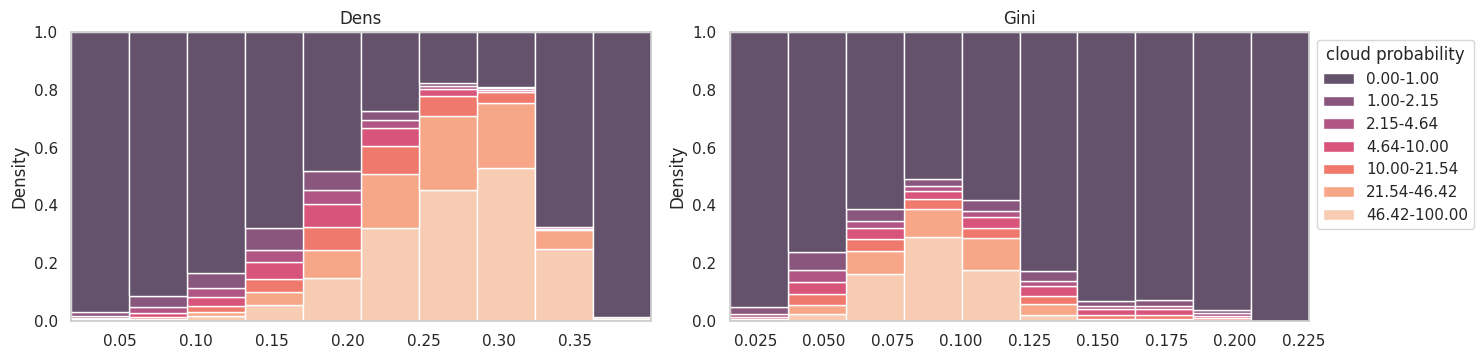

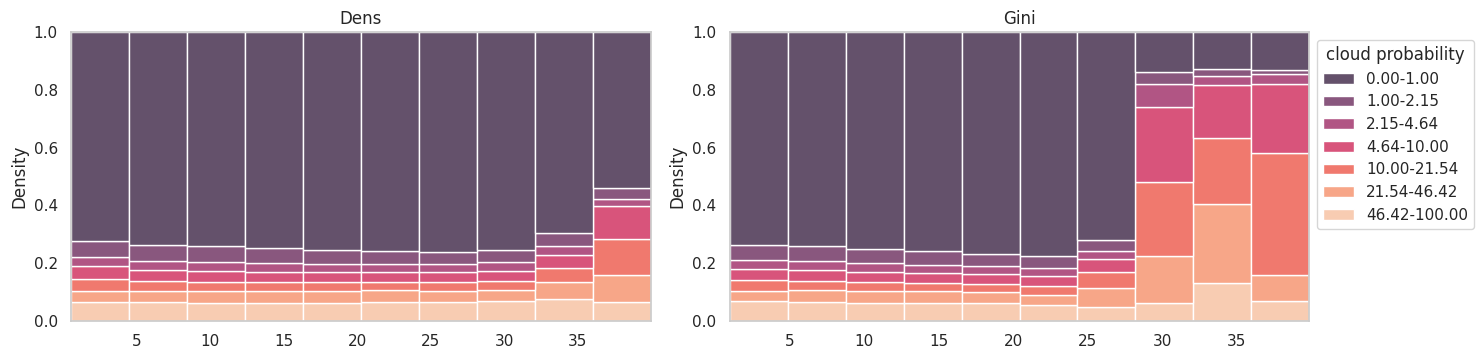

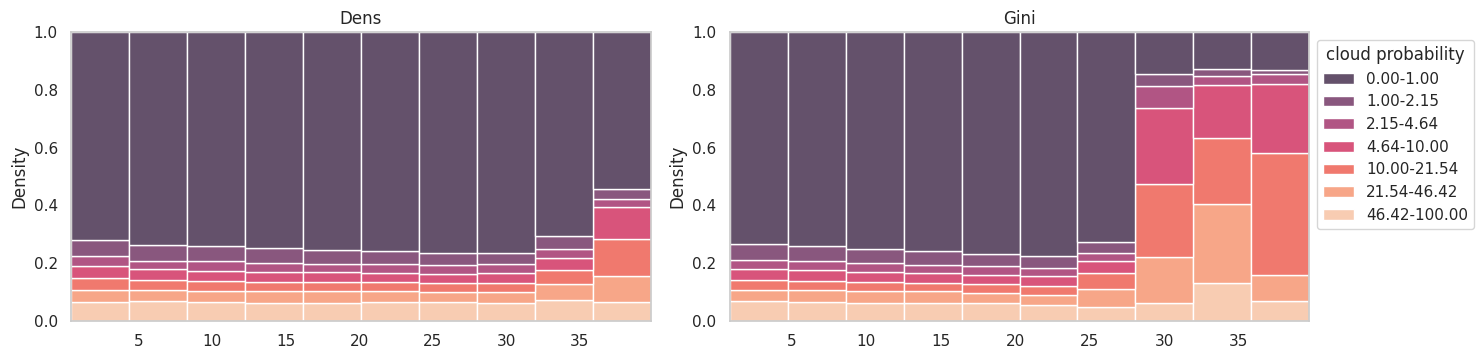

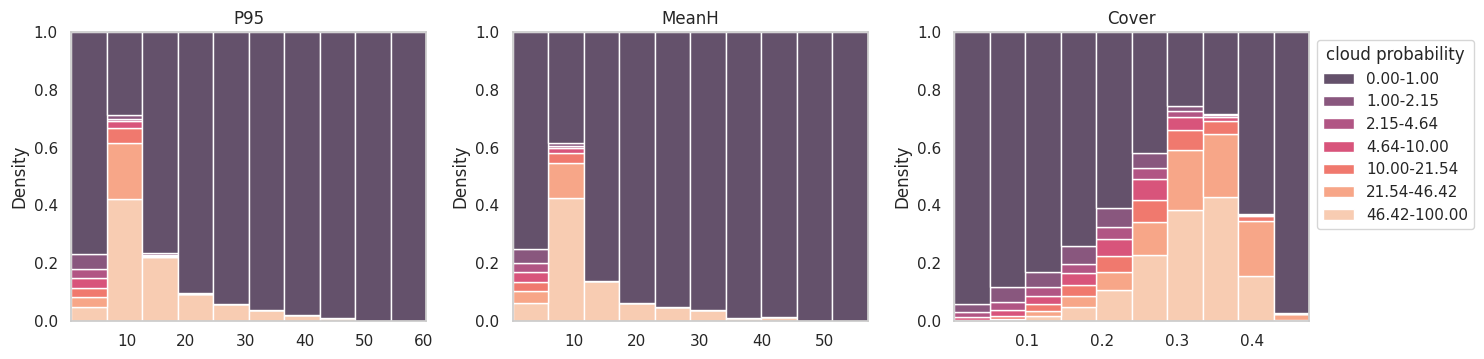

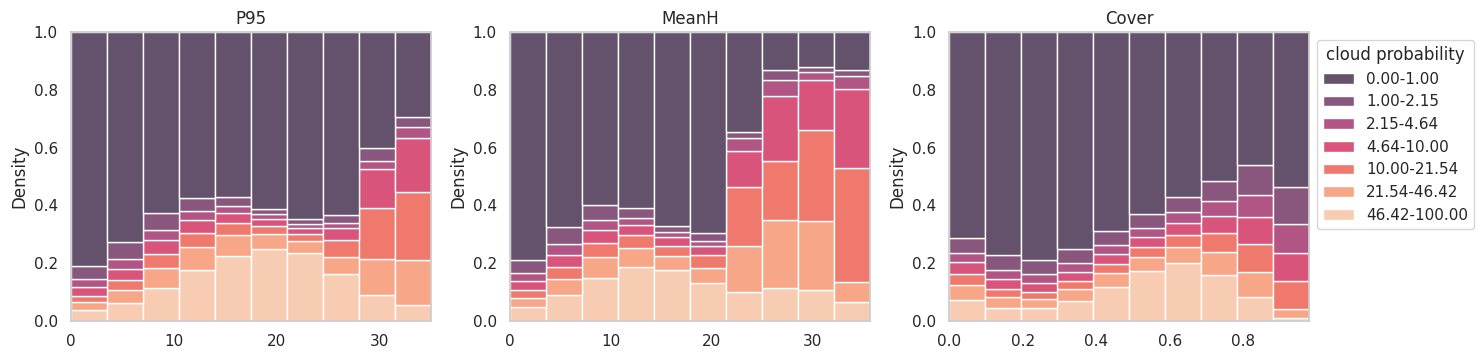

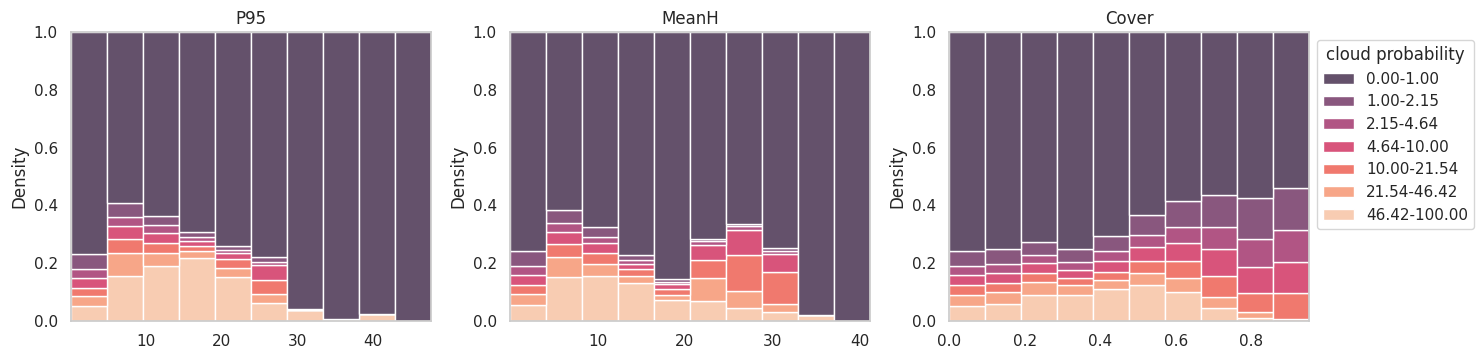

In [135]:
showConditionalHistograms(common_norm=True)

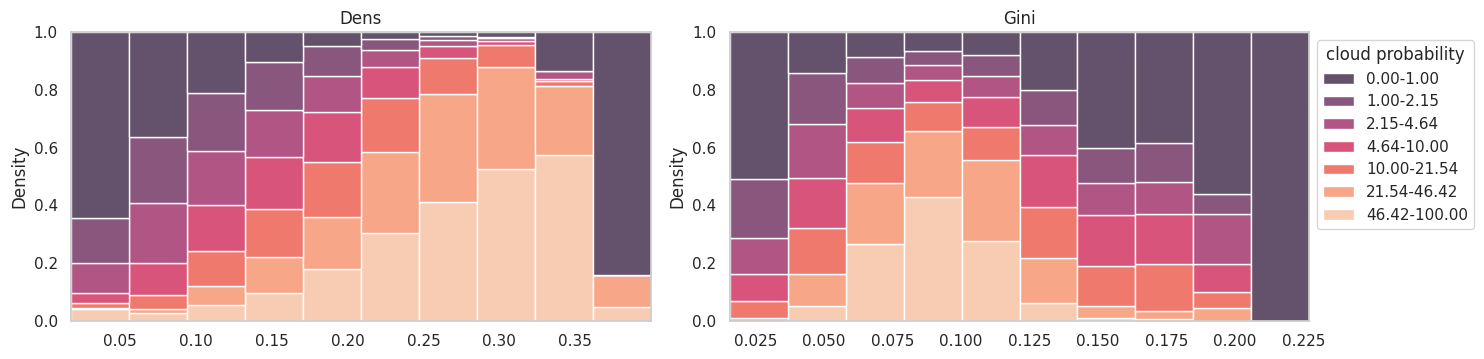

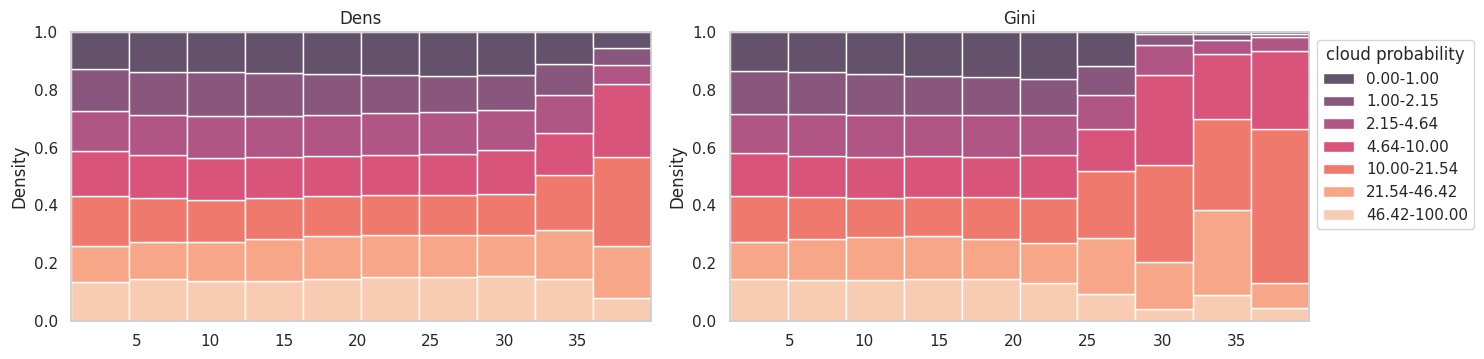

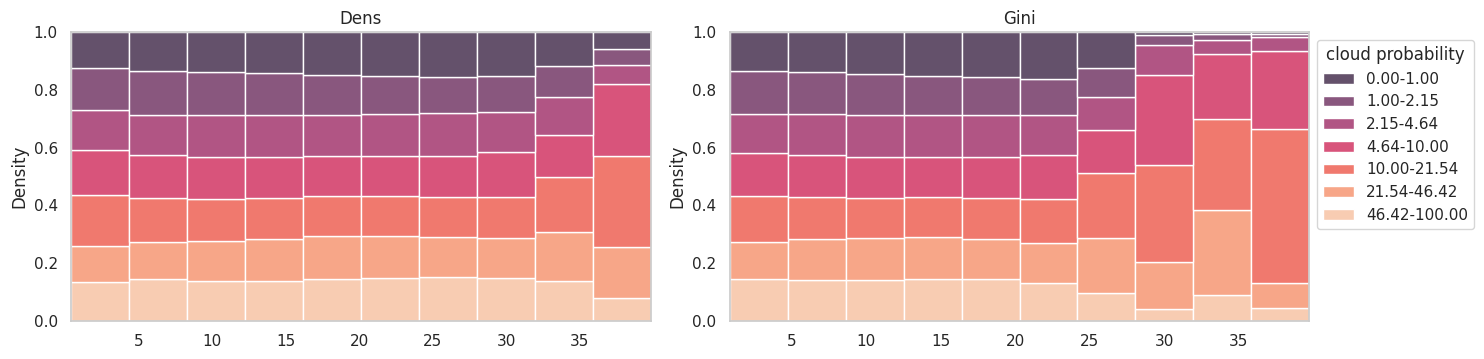

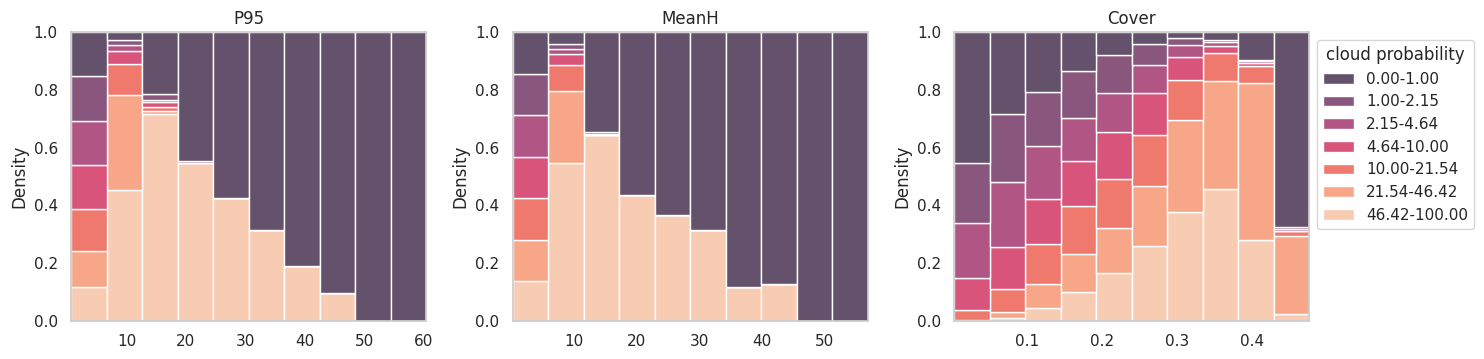

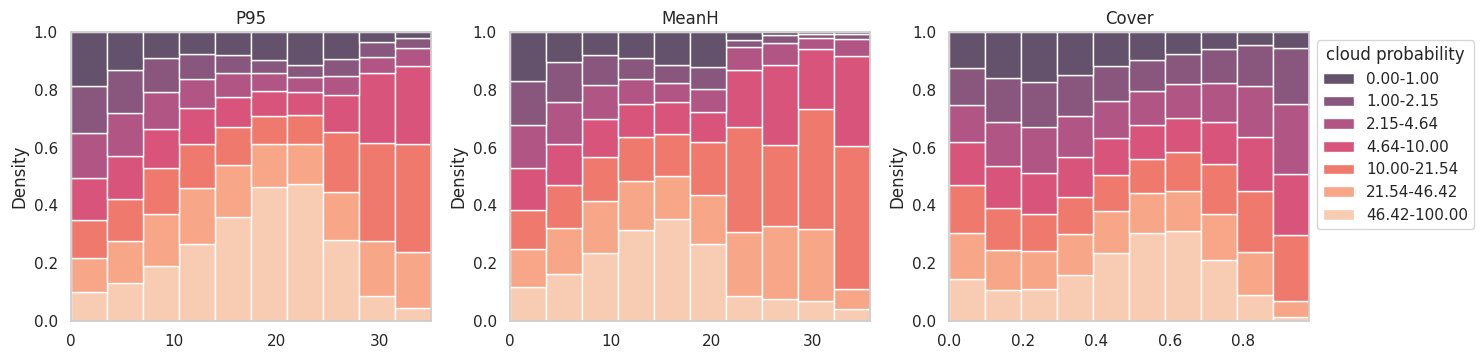

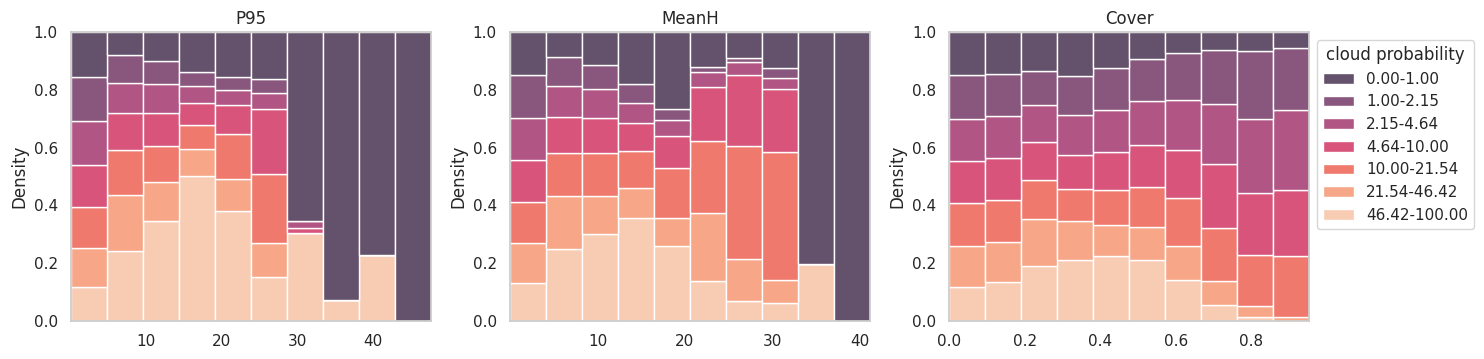

In [137]:
showConditionalHistograms(common_norm=False)